In [132]:
!pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [84]:
import json
#from pinecone import Pinecone, ServerlessSpec
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import PineconeException
import pinecone
import re
import ollama
from transformers import AutoTokenizer
from datetime import datetime

In [85]:
# initialize pinecone config
# just run one time
PINECONE_API_KEY = "63651404-1b59-483a-9c49-0b5c6b3aa9ee"
pc = Pinecone(api_key = PINECONE_API_KEY)
#pinecone.init(api_key=PINECONE_API_KEY, environment="us-east-1-aws")
index_name = "news-articles"

index = pc.Index(index_name)

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [86]:
#Loading the data from the input file
def load_data(filename):
    non_ascii_re = re.compile(r'[^\x00-\x7F]')

    with open(filename, 'r', encoding='utf-8') as infile:
        data = []
        for line in infile:
            record = json.loads(line)
            cleaned_record = {k: non_ascii_re.sub(' ', v) if isinstance(v, str) else v for k, v in record.items()}
            data.append(cleaned_record)
    return data

In [87]:
#Creating Chunks of data, encoding them and then pushing them into the vector DB pinecone
def populate_vectorDB(data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

    chunks_with_metadata = []
    for doc in data:
        metadata = {k: doc[k] for k in doc}
        metadata["published"] = int(datetime.strptime(metadata["published"], "%Y-%m-%dT%H:%M:%SZ").timestamp() * 1000)
        chunks = text_splitter.split_text(doc["content"])
        
        for chunk in chunks:
            chunks_with_metadata.append({
                "text": chunk,
                "metadata": metadata
            })
    print("chunks created.")
    
    for chunk_data in chunks_with_metadata:
        chunk_text = chunk_data["text"]
        metadata = chunk_data["metadata"]
    
        try:
            chunk_embedding = embedding_model.encode(chunk_text).tolist()
            
            #Storing the vector in Pinecone
            index.upsert(vectors=[{
                "id": f"{metadata['title']}_{hash(chunk_text)}",
                "values": chunk_embedding,
                "metadata": metadata
            }])
        except Exception as e:
            print(f"Skipping chunk due to metadata size limit: {e}")
            continue
    
    print("Chunks and metadata have been successfully stored in Pinecone.")


In [88]:
def load_queries(filename):

    query_list = []
    with open(filename, 'r') as jsonl_file:
        for line in jsonl_file:
            query_list.append(json.loads(line))

    return query_list

In [89]:
#Extract Metadata from Query to do filtering on PineCone chunks

def extract_metadata(query_list, query_elements_to_be_considered, metadata_elements_to_be_considered):
    
    list_of_queries_metadata = []
    for queries in query_list:

        query_list_of_elements_to_be_considered = [queries[element] for element in query_elements_to_be_considered]

        for query in query_list_of_elements_to_be_considered:
            prompt = f'''
                You are an expert in identifying patterns in text. 
                ##Task
                Detect and extract the metadata from a given text based on the metadata schema provided.
                Metadata schema:-
                {{
                "published": Date,
                "source": A news source agency as String,
                "media-type": either "News" or "Blog" as String
                }}
                
                If the mentioned published date is "before" a required date, then use "{{$lte: Date}}".
                If the mentioned published date is "after" a required date, then use "{{$gte: Date}}".
                
                Example1:
                Valid input text and detected metadata values:-
                Input query: "Give me news from Brisbane Times published before 22nd September, 2023"
                Detected metadata values:-
                {{
                "published": {{"$lte": "2023-09-22T00:00:00Z"}},
                "source": "Brisbane Times",
                "media-type": "News"
                }}
                
                Example2:
                Valid input text and detected metadata values:-
                Input query: "Give me news from Brisbane Times published after 22nd September, 2023"
                Detected metadata values:-
                {{
                "published": {{"$gte": "2023-09-22T00:00:00Z"}},
                "source": "Brisbane Times",
                "media-type": "News"
                }}
                
                
                
                Return the metadata values in JSON format enclosed between <JSON Start> and <JSON End>.
                If you do not detect any of published, source or media-type do not include it in the metadata JSON output.
                Do not give me the code of how you do it. Just give me the final metadata.
                
                Input text: {query}
            '''

            print("Prompt is:", prompt)
            
            stream = ollama.chat(
                model='llama3.1',
                messages=[{'role': 'user', 'content': prompt}],
                stream=True,
                options={'temperature': 0.0}
            )
            
            response_content = ''
            for chunk in stream:
                response_content += chunk['message']['content']
            
            print("--------------------------------------------------------------")
            print("Response is: ",response_content)

            #Appropriate metadata should be between <JSON Start> and <JSON End> OR </JSON End>
            matches = re.finditer(r"<JSON Start>(.*?)<[/]?JSON End>", response_content, re.DOTALL)
            
            actual_output = ""
            if matches:
                for match in matches:
                    actual_output = match.group(1).strip()
                    print("Actual Output:",actual_output)
                
            try:
                metadata = json.loads(actual_output)
            except json.JSONDecodeError:
                print("JSON Decode Error;")
                metadata = {}
                        
            print("Extracted Metadata: ",metadata)
        
            metadata = {key: metadata[key] for key in metadata_elements_to_be_considered if key in metadata}            

            #If any of the elements are None in the dataset, we remove them from the JSON instead of sending them as null to pinecone
            if "published" in metadata and metadata["published"]==None:
                print("Removing published")
                del metadata["published"]
            if "source" in metadata and metadata["source"]==None:
                print("Removing Source")
                del metadata["source"]
            
            if "published" in metadata and "$lte" in metadata["published"]:
                before_string = metadata["published"]["$lte"] 
                metadata["published"]["$lte"] = int(datetime.strptime(before_string, "%Y-%m-%dT%H:%M:%SZ").timestamp() * 1000)
            if "published" in metadata and "$gte" in metadata["published"]:
                after_string = metadata["published"]["$gte"] 
                metadata["published"]["$gte"] = int(datetime.strptime(after_string, "%Y-%m-%dT%H:%M:%SZ").timestamp() * 1000)
            # if len(metadata)!=0:
            list_of_queries_metadata.append((query,metadata))
        
            print("-----------------------------------------------------------------------------------------------------------")

    return list_of_queries_metadata

In [90]:
# get K relevant docs and construct query and context for final LLM call

def get_k_relevant_docs_from_pinecone(list_of_queries_metadata, overall_k, top_k):
    
    # query_context_list = []
    query_docs_dict={} #Stores key as query and value as list of documents with that title(one of the top k titles)
    
    for query_metadata in list_of_queries_metadata:

        query = query_metadata[0]
        print("Query is:", query)
        print("Metadata is: ",query_metadata[1])
        
        query_embedding = embedding_model.encode(query).tolist()
        
        similar_docs = index.query(vector = query_embedding, top_k = overall_k, include_metadata = True,filter = query_metadata[1])
        
        print("Number of chunks returned is:------>", len(similar_docs["matches"]))
        
        context = ""
        record_matches={} #Stores document title as key and a list of the similarity scores as value
        title_content_map = {} #Stores document title and its content
        
        for match in similar_docs["matches"]:
            #Extract title(without appended hash) and record it in title_content_map (value in map gets overridden everytime the title is found as a key)
            id = match['id']
            print("Id, ",id)
            score = match['score']
            last_index = id.rfind('_')
            title = ""
            
            if last_index==-1:
                title = id
            else:
                title = id[:last_index]
            title_content_map[title] = match["metadata"]["content"]
            
            if title not in record_matches:
                record_matches[title] = [score]
            else:
                record_matches[title].append(score)
        
        #Find average of the similarity score list and store that as value instead
        for title,scores in record_matches.items():
            record_matches[title] = sum(scores)/len(scores)

        #Sort the record_matches dict by its value element since we only want the top k docs
        sorted_matches = dict(sorted(record_matches.items(), key=lambda item: item[1],reverse = True))
        
        print("Number of docs formed from chunks is: ", len(sorted_matches))

        #Populating query_docs_dict dict by finding documents with the title that was in the top k titles
        query_docs_dict[query] = []
        remaining_k = top_k
        for title in sorted_matches.keys():
            query_docs_dict[query].append(title_content_map[title].strip())
            # context = context + "Article:-\n" + title_content_map[title] + "\n\n"
            remaining_k -= 1
            print("\n@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@k:", remaining_k)
            if remaining_k == 0:
                break

        ###########################################################We aren't doing anything with query_context_list
        # print(context)
        # if len(context.strip())!=0:
        #     query_context_list.append((query,context.strip()))

    return query_docs_dict

In [91]:
# Pass each top k document of a query to the LLM and ask it to summarize it in 300 words
def summarize_top_k_documents(dict_of_queries_and_relevant_docs):
    
    # query_reduced_context = []

    #Dict with query as key and top k documents summarized into 300 words (all joined in a string) as value
    query_final_context = {}
    
    print("Number of queries:", len(dict_of_queries_and_relevant_docs))
    
    for q, docs in dict_of_queries_and_relevant_docs.items():
    
        print("Query is: ", q)
        print("Number of docs for above query:", len(docs))

        query_final_context[q] = ""
        for doc in docs:
            
            prompt = f"""
            You are an expert in summarizing news/blog articles retaining the important information and elements of the text.
            Strictly limit the output summary to 300 words.
            article:{doc}
            """
            print("Prompt is: ", prompt)
            
            stream = ollama.chat(
                model='llama3.1',
                messages=[{'role': 'user', 'content': prompt}],
                stream=True,
                options = {'num_ctx':4096}
            )
    
            response_content = ''
            for chunk in stream:
                response_content += chunk['message']['content']
    
            print("Response Stream:", response_content)
            print("-----------------------------------------")
            query_final_context[q]+= response_content + "\n----------\n"
    
    return query_final_context

In [92]:
#Call LLM to get the final summarized results after RAG

def get_summarization(dict_of_queries_and_context):

    print("Number of queries: ", len(dict_of_queries_and_context))

    #List of tuples (query, context, LLM response content)
    query_context_response_list = []
    for q,context in dict_of_queries_and_context.items():
    
        prompt = f"""
        *###IMPORTANT*: Restrict yourself to the provided context and do not include any information that is not present in the context.
        You are an expert in answering queries by using the provided context. Strictly use the provided context and query to create a news summary.
        Follow the procdure below:-
        - while generating each sentence, verify whether the generated content does not have any information which is not present in the context.
        query: {q}
        context: {context}"""
        prompt = " ".join(prompt.split()[:1500])
        
        print("Prompt: ",prompt)
        
        stream = ollama.chat(
            model='llama3.1',
            messages=[{'role': 'user', 'content': prompt}],
            stream=True,
            options = {'num_ctx':4096}
        )
        
        response_content = ''
        for chunk in stream:
            response_content += chunk['message']['content']
        
        print("--------------------------------------------------------------")
        print("Response Content is: ",response_content)
        # query_context_response_list[q] = {(context, response_content)}
        query_context_response_list.append((q,context,response_content))
    
    return query_context_response_list

In [117]:
def plot_line_chart(arg1, arg2, avg_arg1, avg_arg2, x_label, y_label, line_label1, line_label2, title):
    
    x_values = list(range(1, len(arg1) + 1))
    
    plt.figure(figsize=(15, 6))
    
    plt.plot(x_values, arg1, marker='o', label=line_label1)
    plt.plot(x_values, arg2, marker='o', label=line_label2)

    plt.axhline(y=avg_arg1, color='blue', linestyle='--', label=f'Avg {line_label1}')
    plt.axhline(y=avg_arg2, color='orange', linestyle='--', label=f'Avg {line_label2}')

    plt.text(len(x_values) + 1, avg_arg1, f'{avg_arg1:.2f}', color='blue', fontsize=10, verticalalignment='center')
    plt.text(len(x_values) + 1, avg_arg2, f'{avg_arg2:.2f}', color='orange', fontsize=10, verticalalignment='center')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

In [95]:
dataset = load_data("news-sample.jsonl")
# populate_vectorDB(dataset)

query_list = load_queries("document_topics_75.jsonl")

query_elements_to_be_considered = ["first_query", "second_question", "third_question", "fourth_question"]
metadata_elements_to_be_considered = ["published","source"]

In [96]:
#list of tuples with each tuple (query, metadata)
list_of_queries_with_metadata = extract_metadata(query_list, query_elements_to_be_considered, metadata_elements_to_be_considered)

Prompt is: 
                You are an expert in identifying patterns in text. 
                ##Task
                Detect and extract the metadata from a given text based on the metadata schema provided.
                Metadata schema:-
                {
                "published": Date,
                "source": A news source agency as String,
                "media-type": either "News" or "Blog" as String
                }
                
                If the mentioned published date is "before" a required date, then use "{$lte: Date}".
                If the mentioned published date is "after" a required date, then use "{$gte: Date}".
                
                Example1:
                Valid input text and detected metadata values:-
                Input query: "Give me news from Brisbane Times published before 22nd September, 2023"
                Detected metadata values:-
                {
                "published": {"$lte": "2023-09-22T00:00:00Z"},
            

In [97]:
print(len(list_of_queries_with_metadata))

100


In [98]:
#dict with query as key and top k relevant document in a list as values
dict_of_queries_and_relevant_docs = get_k_relevant_docs_from_pinecone(list_of_queries_with_metadata, 50, 5)

Query is: Give me latest news about security
Metadata is:  {}
Number of chunks returned is:------> 50
Id,  Join @AlertLogic at @DevOpsSummit Silicon Valley | #DevOps #BigData #API #Containers #Microservices_-2728208247228966080
Id,  Join @AlertLogic at @DevOpsSummit Silicon Valley | #DevOps #BigData #API #Containers #Microservices_-1682193386287031579
Id,  Rupee trading at over 66 to the dollar Sensex down 25 points in early trade_3075236968123712369
Id,  Join @AlertLogic at @DevOpsSummit Silicon Valley | #DevOps #BigData #API #Containers #Microservices_-5514657826889476623
Id,  US spies can be blocked from accessing Europeans' online data - court_8121685404698789437
Id,  Join @AlertLogic at @DevOpsSummit Silicon Valley | #DevOps #BigData #API #Containers #Microservices_-1720213494255312065
Id,  US spies can be blocked from accessing Europeans' online data - court_8322514500890463474
Id,  Mounted police deploy downtown to ease fears_-5130374036967974717
Id,  Brits say go easy on the se

In [99]:
# print(dict_of_queries_and_relevant_docs)
# print(len(dict_of_queries_and_relevant_docs))
# print(len(dict_of_queries_and_relevant_docs['Give me latest news about security']))

In [100]:
#dict with query as key and top k documents summarized into 300 words as a joined string
dict_of_queries_and_reduced_docs = summarize_top_k_documents(dict_of_queries_and_relevant_docs)

Number of queries: 90
Query is:  Give me latest news about security
Number of docs for above query: 5
Prompt is:  
            You are an expert in summarizing news/blog articles retaining the important information and elements of the text.
            Strictly limit the output summary to 300 words.
            article:SYS-CON Events announced today that Alert Logic, the leading provider  of Security-as-a-Service solutions for the cloud, has been named  "Bronze Sponsor" of SYS-CON's 17th International Cloud Expo   and DevOps Summit 2015 Silicon Valley, which will take place November 3-5, 2015, at the Santa Clara Convention Center in Santa Clara, CA. 
 
Alert Logic provides Security-as-a-Service for on-premises, cloud,  and hybrid IT infrastructures, delivering deep security insight and  continuous protection for customers at a lower cost than traditional  security solutions. 
 
Fully managed by a team of security and compliance experts, the Alert  Logic Security-as-a-Service solution p

In [101]:
# print(dict_of_queries_and_reduced_docs)
# print(len(dict_of_queries_and_reduced_docs))
# print(dict_of_queries_and_reduced_docs['Give me latest news about security'])

In [102]:
#list of tuples with query, reduced context and llm_response with that content
list_of_queries_and_optimal_context_and_llm_response = get_summarization(dict_of_queries_and_reduced_docs)

Number of queries:  90
Prompt:  *###IMPORTANT*: Restrict yourself to the provided context and do not include any information that is not present in the context. You are an expert in answering queries by using the provided context. Strictly use the provided context and query to create a news summary. Follow the procdure below:- - while generating each sentence, verify whether the generated content does not have any information which is not present in the context. query: Give me latest news about security context: Here is a summary of the article in 300 words: SYS-CON Events announced that Alert Logic, a leading provider of Security-as-a-Service solutions for the cloud, has been named Bronze Sponsor of SYS-CON's 17th International Cloud Expo and DevOps Summit 2015 Silicon Valley. Alert Logic provides Security-as-a-Service for on-premises, cloud, and hybrid IT infrastructures, delivering deep security insight and continuous protection at a lower cost than traditional security solutions. T

In [103]:
# print(len(list_of_queries_and_optimal_context_and_llm_response))
# print(list_of_queries_and_optimal_context_and_llm_response[0][0]) #Query
# print(list_of_queries_and_optimal_context_and_llm_response[0][1]) #Context
print(list_of_queries_and_optimal_context_and_llm_response[0][2]) #Results

Here is a news summary based on the provided context:

**Latest News:**

* Alert Logic has been named Bronze Sponsor of SYS-CON's 17th International Cloud Expo and DevOps Summit 2015 Silicon Valley.
* The company will present two sessions at the conference, including "Proactive vs. Reactive - A Better Approach to Cloud Security" on November 3.
* New Castle County mounted police have increased their presence in Rodney Square, Wilmington, following a recent stabbing incident.

**Security News:**

* Alert Logic provides Security-as-a-Service for on-premises, cloud, and hybrid IT infrastructures, delivering deep security insight and continuous protection at a lower cost than traditional security solutions.
* The company partners with all major cloud platforms and hosting providers to protect over 3,000 organizations worldwide.

**No additional news was found in the provided context related to other topics such as SiriusXM, The Hill, India-related News, PM Modi's US Visit, Other News.


In [104]:
def encode_full_corpus(dataset):
    full_corpus = ""
    for doc in dataset:
        full_corpus += doc['content']

    full_corpus_embedding = embedding_model.encode(full_corpus).tolist()
    return full_corpus_embedding

def get_full_corpus_as_string(dataset):

    full_corpus_as_string = ""
    for data in dataset:
        full_corpus_as_string += data['content']

    return full_corpus_as_string

Avg cosine similarity between Query and Contexts (without RAG) is:  0.010591476343125314
Avg cosine similarity between Query and Contexts (with RAG) is:  0.3376511804764925


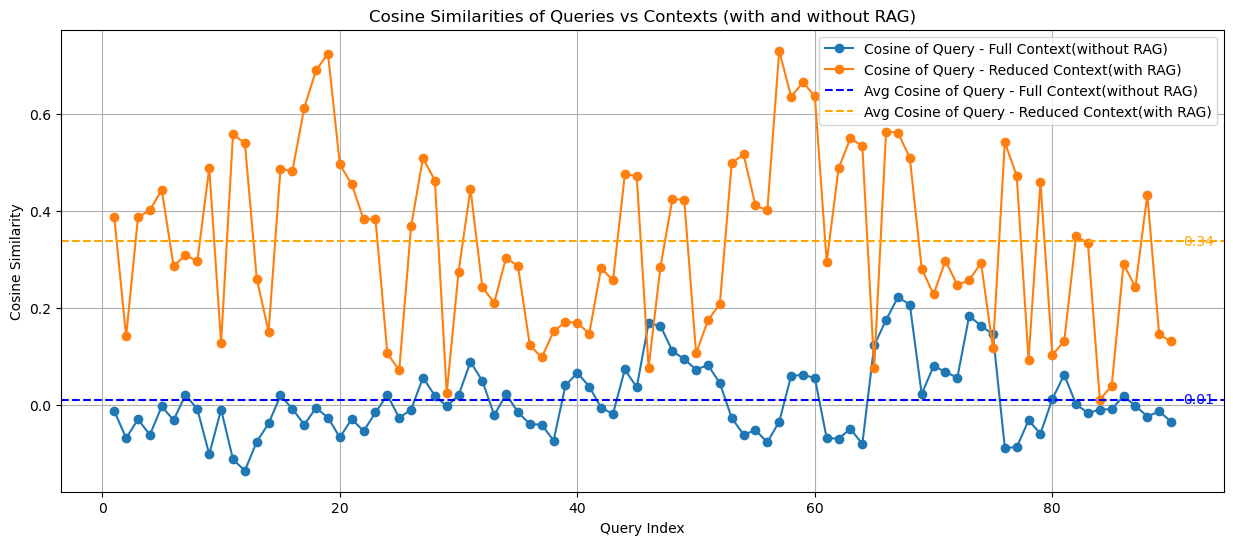

In [118]:
#Finding Cosine Similarity of Query - Full Corpus and Query - Reduced Corpus
#This shows how the reducing of the corpus has helped

full_corpus_embedding = encode_full_corpus(dataset)

all_cosine_between_query_and_full_corpus = []
all_cosine_between_query_and_reduced_corpus = []

for query,context in dict_of_queries_and_reduced_docs.items():

    reduced_corpus_embedding = embedding_model.encode(context).tolist()
    query_embedding = embedding_model.encode(query).tolist()

    cosine_between_query_and_full_corpus = cosine_similarity([query_embedding], [full_corpus_embedding])[0][0]
    cosine_between_query_and_reduced_corpus = cosine_similarity([query_embedding], [reduced_corpus_embedding])[0][0]

    all_cosine_between_query_and_full_corpus.append(cosine_between_query_and_full_corpus)
    all_cosine_between_query_and_reduced_corpus.append(cosine_between_query_and_reduced_corpus)

avg_all_cosine_between_query_and_full_corpus = sum(all_cosine_between_query_and_full_corpus)/len(all_cosine_between_query_and_full_corpus)
avg_all_cosine_between_query_and_reduced_corpus = sum(all_cosine_between_query_and_reduced_corpus)/len(all_cosine_between_query_and_reduced_corpus)

print("Avg cosine similarity between Query and Contexts (without RAG) is: ", avg_all_cosine_between_query_and_full_corpus)
print("Avg cosine similarity between Query and Contexts (with RAG) is: ", avg_all_cosine_between_query_and_reduced_corpus)

plot_line_chart(
    all_cosine_between_query_and_full_corpus, 
    all_cosine_between_query_and_reduced_corpus, 
    avg_all_cosine_between_query_and_full_corpus,
    avg_all_cosine_between_query_and_reduced_corpus,
    "Query Index", 
    "Cosine Similarity", 
    "Cosine of Query - Full Context(without RAG)", 
    "Cosine of Query - Reduced Context(with RAG)", 
    "Cosine Similarities of Queries vs Contexts (with and without RAG)"
)

In [113]:

#Now, we want to find cosine similarity of fullcorpus - response for full corpus and reducedcorpus - response for reduced corpus
#This helps us show whether reducing the corpus played a part in the LLM Response

#We already have reducedCorpus and response (thats our optimal flow, we have that saved in list_of_queries_and_context_and_llm_response
#We need to find the fullCorpus and response. For that we can reuse the get_summarization and pass a dict with queries and each query having fullCorpus as values
dict_of_queries_and_full_docs = {}

full_corpus_as_string = get_full_corpus_as_string(dataset)

#We use the same queries as the ones in optimal flow()
for query, reduced_corpus in dict_of_queries_and_reduced_docs.items():
    dict_of_queries_and_full_docs[query] = full_corpus_as_string

list_of_queries_and_full_context_and_llm_response = get_summarization(dict_of_queries_and_full_docs)

Number of queries:  90
Prompt:  *###IMPORTANT*: Restrict yourself to the provided context and do not include any information that is not present in the context. You are an expert in answering queries by using the provided context. Strictly use the provided context and query to create a news summary. Follow the procdure below:- - while generating each sentence, verify whether the generated content does not have any information which is not present in the context. query: Give me latest news about security context: VETERANS saluted Worcester's first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar

Avg cosine similarity between Query and Result (without RAG) is:  0.6165803320051167
Avg cosine similarity between Query and Results (with RAG) is:  0.5975723779653564


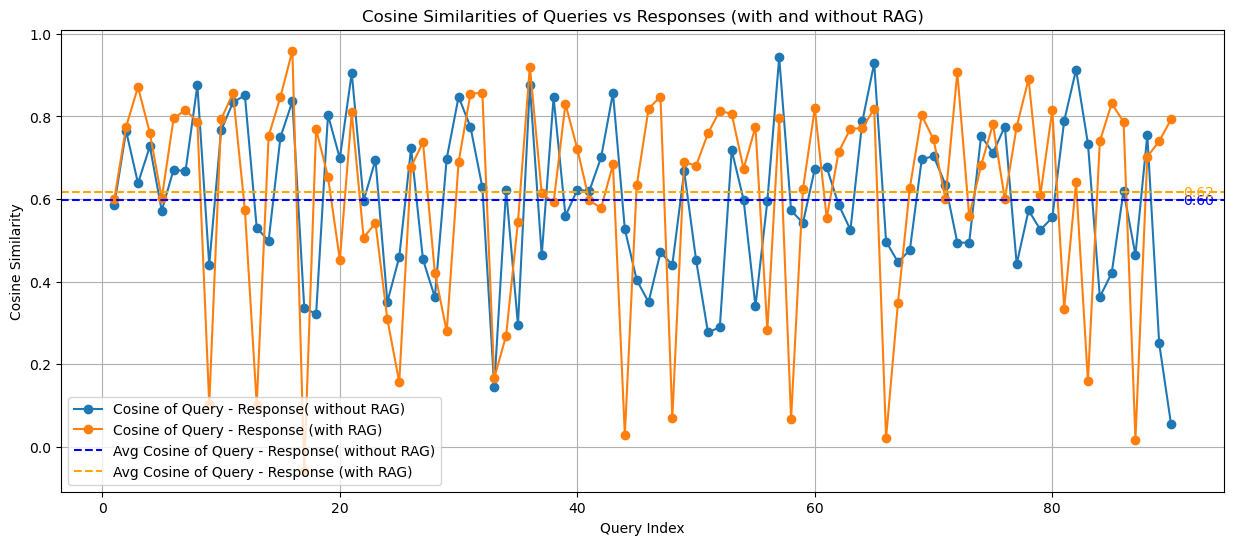

In [119]:
#Now we have the list of queries with optimal corpus and those results - list_of_queries_and_optimal_context_and_llm_response
#And we have list of queries with full corpus and those results - list_of_queries_and_full_context_and_llm_response

#We need to find cosine similarity of Query vs OptimalResponse and Query vs FullResponse
#This will show us how the RAG (optimalResponse) helps in final response


#Lets sort the lists first since we need the 0th element of tuples(query) to be in same order
sorted_list_of_queries_and_optimal_context_and_llm_response = sorted(list_of_queries_and_optimal_context_and_llm_response) #Sorts with respect to 0th element by default
sorted_list_of_queries_and_full_context_and_llm_response = sorted(list_of_queries_and_full_context_and_llm_response)

list_of_cosines_between_query_and_optimal_context_response = []
list_of_cosines_between_query_and_full_context_response = []

for i in range(len(sorted_list_of_queries_and_optimal_context_and_llm_response)):

    query = sorted_list_of_queries_and_optimal_context_and_llm_response[i][0] #Query is common for both
    optimal_context_response = sorted_list_of_queries_and_optimal_context_and_llm_response[i][2]
    full_context_response = sorted_list_of_queries_and_full_context_and_llm_response[i][2]

    query_embedding = embedding_model.encode(query).tolist()
    optimal_context_response_embedding = embedding_model.encode(optimal_context_response).tolist()
    full_context_response_embedding = embedding_model.encode(full_context_response).tolist()

    cosine_between_query_and_optimal_context_response = cosine_similarity([query_embedding], [optimal_context_response_embedding])[0][0]
    cosine_between_query_and_full_context = cosine_similarity([query_embedding], [full_context_response_embedding])[0][0]

    list_of_cosines_between_query_and_optimal_context_response.append(cosine_between_query_and_optimal_context_response)
    list_of_cosines_between_query_and_full_context_response.append(cosine_between_query_and_full_context)

avg_list_of_cosines_between_query_and_full_context_response = sum(list_of_cosines_between_query_and_full_context_response)/len(list_of_cosines_between_query_and_full_context_response)
avg_list_of_cosines_between_query_and_optimal_context_response = sum(list_of_cosines_between_query_and_optimal_context_response)/len(list_of_cosines_between_query_and_optimal_context_response)

print("Avg cosine similarity between Query and Result (without RAG) is: ", avg_list_of_cosines_between_query_and_full_context_response)
print("Avg cosine similarity between Query and Results (with RAG) is: ", avg_list_of_cosines_between_query_and_optimal_context_response)


plot_line_chart(
    list_of_cosines_between_query_and_optimal_context_response, 
    list_of_cosines_between_query_and_full_context_response, 
    avg_list_of_cosines_between_query_and_optimal_context_response,
    avg_list_of_cosines_between_query_and_full_context_response,
    "Query Index", 
    "Cosine Similarity", 
    "Cosine of Query - Response( without RAG)", 
    "Cosine of Query - Response (with RAG)",
    "Cosine Similarities of Queries vs Responses (with and without RAG)"
)

Avg cosine similarity between Context and Result (without RAG) is:  0.2638285977250529
Avg cosine similarity between Context and Results (with RAG) is:  0.5090920612441944


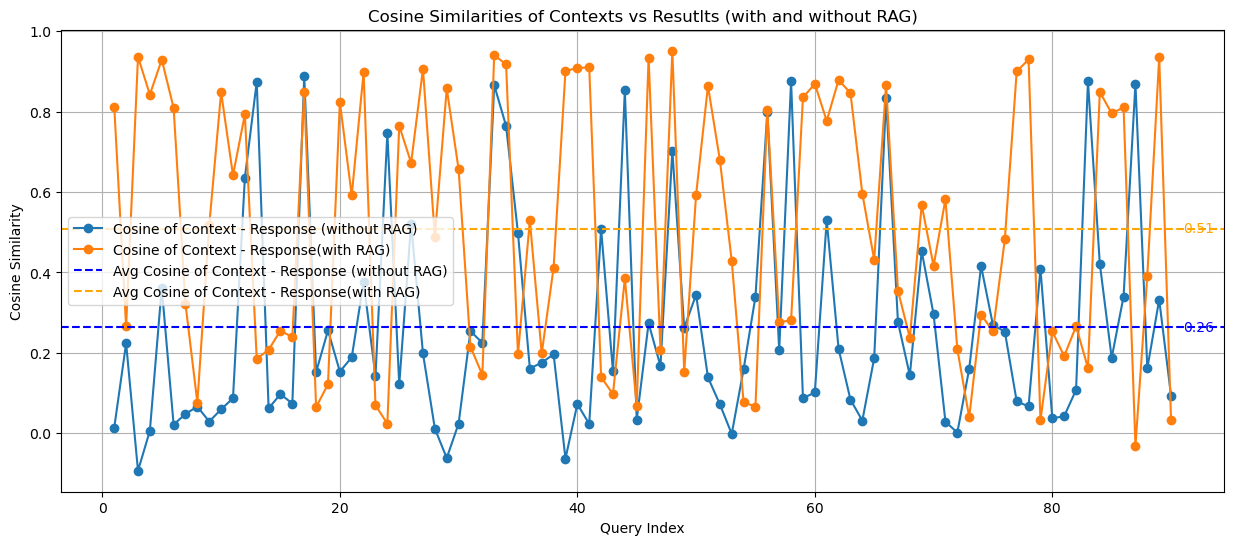

In [121]:
#We have done query vs results(optimal vs full), we have done query vs corpus(optimal vs full)
#We should now do results(optimal, full) vs corpus(optimal, full)

#We already have all the information for this already
#list_of_queries_and_full_context_and_llm_response - has query, fullContext, ResponsewithFullContext
#list_of_queries_and_optimal_context_and_llm_response - has query, optimalContext, ResponsewithOptimalContext

sorted_list_of_queries_and_optimal_context_and_llm_response = sorted(list_of_queries_and_optimal_context_and_llm_response) #Sorts with respect to 0th element by default
sorted_list_of_queries_and_full_context_and_llm_response = sorted(list_of_queries_and_full_context_and_llm_response)

list_of_cosines_between_optimal_context_and_optimal_context_response = []
list_of_cosines_between_full_context_and_full_context_response = []

# full_context_as_string = get_full_corpus_as_string(dataset)
full_context_embedding = encode_full_corpus(dataset)

for i in range(len(sorted_list_of_queries_and_optimal_context_and_llm_response)):

    response_with_optimal_context = sorted_list_of_queries_and_optimal_context_and_llm_response[i][2]
    response_with_full_context = sorted_list_of_queries_and_full_context_and_llm_response[i][2]
    optimal_context = sorted_list_of_queries_and_optimal_context_and_llm_response[i][1]
    full_context = sorted_list_of_queries_and_full_context_and_llm_response[i][1]

    response_with_optimal_context_embedding = embedding_model.encode(response_with_optimal_context).tolist()
    response_with_full_context_embedding = embedding_model.encode(response_with_full_context).tolist()
    optimal_context_embedding = embedding_model.encode(optimal_context).tolist()
    # full_context_embedding = embedding_model.encode(full_context).tolist()  #since this would be very heavy computationally and will not change, we have done it outside the loop

    cosine_between_response_with_optimal_context_embedding_and_optimal_context_embedding = cosine_similarity([response_with_optimal_context_embedding], [optimal_context_embedding])[0][0]
    cosine_between_response_with_full_context_embedding_and_full_context_embedding = cosine_similarity([response_with_full_context_embedding], [full_context_embedding])[0][0]

    list_of_cosines_between_full_context_and_full_context_response.append(cosine_between_response_with_full_context_embedding_and_full_context_embedding)
    list_of_cosines_between_optimal_context_and_optimal_context_response.append(cosine_between_response_with_optimal_context_embedding_and_optimal_context_embedding)

avg_list_of_cosines_between_full_context_and_full_context_response = sum(list_of_cosines_between_full_context_and_full_context_response)/len(list_of_cosines_between_full_context_and_full_context_response)
avg_list_of_cosines_between_optimal_context_and_optimal_context_response = sum(list_of_cosines_between_optimal_context_and_optimal_context_response)/len(list_of_cosines_between_optimal_context_and_optimal_context_response)

print("Avg cosine similarity between Context and Result (without RAG) is: ", avg_list_of_cosines_between_full_context_and_full_context_response)
print("Avg cosine similarity between Context and Results (with RAG) is: ", avg_list_of_cosines_between_optimal_context_and_optimal_context_response)

plot_line_chart(
    list_of_cosines_between_full_context_and_full_context_response, 
    list_of_cosines_between_optimal_context_and_optimal_context_response, 
    avg_list_of_cosines_between_full_context_and_full_context_response,
    avg_list_of_cosines_between_optimal_context_and_optimal_context_response,
    "Query Index", 
    "Cosine Similarity", 
    "Cosine of Context - Response (without RAG)", 
    "Cosine of Context - Response(with RAG)",
    "Cosine Similarities of Contexts vs Resutlts (with and without RAG)"
)

In [130]:
##################################################################################################################################################################